## AHRS algorithm comparison

Author:　Ｈsiu-Wen Chang
Date: 2022.06.21

The purpose of this notebook is to evaluate the performance of several AHRS algorithms with high dynamic body acceleration dataset. We check the performance of each AHRS not only in attitude domain but also position domain.

| Algorithm     | Gyroscope | Accelerometer | Magnetometer |
|---------------|:---------:|:-------------:|:------------:|
| AQUA          | YES       | YES           | Optional     |
| Complementary | YES       | YES           | Optional     |
| Davenport's   | NO        | YES           | YES          |
| EKF           | YES       | YES           | YES          |
| FAMC          | NO        | YES           | YES          |
| FLAE          | NO        | YES           | YES          |
| Fourati       | YES       | YES           | YES          |
| FQA           | NO        | YES           | Optional     |
| Integration   | YES       | NO            | NO           |
| Madgwick      | YES       | YES           | Optional     |
| Mahony        | YES       | YES           | Optional     |
| OLEQ          | NO        | YES           | YES          |
| QUEST         | NO        | YES           | YES          |
| ROLEQ         | YES       | YES           | YES          |
| SAAM          | NO        | YES           | YES          |
| Tilt          | NO        | YES           | Optional     |
| TRIAD         | NO        | YES           | YES          |

In [1]:
%matplotlib notebook 

import numpy as np
import glob
import os
import matplotlib.pyplot as plt
# Please pay attention to your path naming system
print(os.getcwd())

/mnt/c/Users/Kelly/Desktop/XW_NCKU project/python/ahrs_robust


Dataset collected on June, 1, 2022

Activity: jogging on a oval shape of sport field with one lap. 
device: OSMIMU, MIMU22BL

format: PKT_No. 	    TimeStamp 	    ax(m/s^2) 	    ay(m/s^2) 	    az(m/s^2) 	    gx(rad/s) 	    gy(rad/s) 	    gz(rad/s) 	       mx(μT) 	       my(μT) 	       mz(μT) 

Reference trajectory by GPS:
<img src="figures/sport_field_ncku.png" width=800 height=800 />
Location on human wraist 
<img src="figures/device_allocation_jogging_04122022.png" width=600 height=600 />



In [2]:
file_root = '../../data/20220601_NCKU_indoor_outdoor_jog/0601/吉歆_操場'
files_sequence = os.listdir(file_root)
#P1211: right wrist, 4 imu array
#P1213: left wrist,  1 imu array
#P1214: left wrist, 4 imu array
print(files_sequence)


['62.5Hz_20220601_165902.txt', 'setting.mat', '磁力計率定']


In [3]:
# practice to get all txt files
counter = 0
for sequence in files_sequence:
    if os.path.isdir(os.path.join(file_root,sequence)):
        files_path = glob.glob(os.path.join(file_root,sequence,'*.txt'))
        counter += len(files_path)
        print(files_path)
print('Total imu files:', counter)


['../../data/20220601_NCKU_indoor_outdoor_jog/0601/吉歆_操場/磁力計率定/62.5Hz_20220601_165807.txt']
Total imu files: 1


In [4]:
seq = os.path.join(file_root,files_sequence[0])
print(files_sequence[0])
print(seq)
imu = np.genfromtxt(seq, skip_header=3)

62.5Hz_20220601_165902.txt
../../data/20220601_NCKU_indoor_outdoor_jog/0601/吉歆_操場/62.5Hz_20220601_165902.txt


In [5]:
print(imu.shape)

(8841, 11)


In [6]:
def draw_raw_data(imu):
    fig, axs = plt.subplots(3, 1, sharex=True)
    axs[0].set(ylabel='accel (m/s/s)', title='MIMU reading')
    axs[1].set(ylabel='gyro (rad/s)')
    axs[2].set(xlabel='$t$ (s)', ylabel='mag (microtesla)')

    for i in range(3):
        axs[i].plot(imu[:,1], imu[:,2+i*3], label='x')
        axs[i].plot(imu[:,1], imu[:,3+i*3], label='y')
        axs[i].plot(imu[:,1], imu[:,4+i*3], label='z')
        axs[i].grid()
        axs[i].legend()

    plt.show()
    
def draw_attitude(ahrs,**kw):
    fig, axs = plt.subplots(3,1,sharex=True)
    axs[0].set(ylabel='roll (deg)',title='Attitude')
    axs[1].set(ylabel='pitch (deg)')
    axs[2].set(ylabel='yaw (deg)')
  
    label_text = kw.get('label_text','None')
    for i in range((ahrs.shape[1]-1)//3):
        if label_text == "None":
            axs[0].plot(ahrs[:,0], ahrs[:,1+i*3]/np.pi*180, label=f"roll_{i}")
            axs[1].plot(ahrs[:,0], ahrs[:,2+i*3]/np.pi*180, label=f"pitch_{i}")
            axs[2].plot(ahrs[:,0], ahrs[:,3+i*3]/np.pi*180, label=f"yaw_{i}")
        else:
            axs[0].plot(ahrs[:,0], ahrs[:,1+i*3]/np.pi*180, label = f"roll_{label_text[i]}")
            axs[1].plot(ahrs[:,0], ahrs[:,2+i*3]/np.pi*180, label=f"pitch_{label_text[i]}")
            axs[2].plot(ahrs[:,0], ahrs[:,3+i*3]/np.pi*180, label=f"yaw_{label_text[i]}")
          
    for i in range(3):
        axs[i].grid()
        axs[i].legend()
    
    plt.show()
    

In [7]:
# 3 km/hr: 72.5 s to 135 s
# 6 km/hr: 135 s to 192 s
# 10 km/hr: 192 s to 253.5 s
draw_raw_data(imu)

<IPython.core.display.Javascript object>

In [8]:
#time_start = 72.5
time_start = 0

time_end = 140
imu2 = imu[(imu[:,1]>time_start) & (imu[:,1]<time_end),:]

In [9]:
draw_raw_data(imu2)

<IPython.core.display.Javascript object>

In [10]:
# Check time tag values
plt.figure()
#plt.plot(np.diff(imu[:,1]))
#plt.ylim(0,0.1)
plt.plot(1/np.diff(imu[:,1]))
plt.ylim(0,100)
print('Average data output rate:', 1/np.mean(np.diff(imu[:,1])))

<IPython.core.display.Javascript object>

Average data output rate: 62.5


# Magwick orientation estimator [2010]
Now lets see the performance of Magwick AHRS algorithm with and without magnetomter
First, we need to find filter gain $\beta$ which represent the all mean zero gyroscope measurement error. Default is 0.033 for IMU and 0.041 for MARG. 

It claims and shows the ability to compensate gyro drift, quote:
This algorithm doens't use Kalman filter. Although the advantage of Kalman-based approaches is that they are able to estimate the gyroscope biasas an additional state within the system model. However, [Mahony et al](https://hal.archives-ouvertes.fr/hal-00488376/document) showed that gyroscope bias drift may also be compensated for by simpler orientation through the integral feedback of the error in the rate of change of orientation.
(However, I did not see the bias internal feedback in the source code. Need to check Magwick original code in C. Corresponding equations are 47 to 49)

It also claims to and shows the ability to compensate magnetic distortion:
Inclination errors, those in the vertical plane relative to the earth's surface, may be compensated for as the accelerometer provides an additional measurement of the sensor's attitude.

<img src="figures/magwick_flowchart.png" width=800 height=800 />

The disadvantage: (1) Magnetic interference is not protected. (2) Objective function $\min f(_{E}^S\mathbf{\hat{q}}, ^E\mathbf{\hat{b}},^S\mathbf{\hat{s}})=_{E}^S\mathbf{\hat{q}}^{*} \bigotimes ^E\mathbf{\hat{d}} \bigotimes _{E}^S\mathbf{\hat{q}}- ^S\mathbf{\hat{s}} $ imply the assumption that rotated reference vectors (gravity in accelerometer and magnetic field in magnetometer) in to sensor frame will make it match the measurements in sensor frame. The assumption is invalid when external force (linear acceleration) and magnetic inference are applied. We will see this issue in treadmill experiment when user starts to jog faster than 7 km/hr. 

In [11]:
import ahrs
from ahrs.common.orientation import q2rpy, q2euler, q2R

In [12]:
# to get intial q_0, run Madwick with mag first to in order to find yaw_0
attitude_magwick_marg = ahrs.filters.Madgwick(acc=imu2[:,2:5], gyr=imu2[:,5:8],mag=imu2[:,8:11],frequency=62)
attitude_magwick = ahrs.filters.Madgwick(acc=imu2[:,2:5], gyr=imu2[:,5:8],q0 = attitude_magwick_marg.Q[0],frequency=62)


In [13]:
euler_angles_magwick = np.asarray([q2euler(s) for s in attitude_magwick.Q]) #this formula is different to wiki
rpy_angles_magwick = np.asarray([q2rpy(s) for s in attitude_magwick.Q])

euler_angles_marg_magwick = np.asarray([q2euler(s) for s in attitude_magwick_marg.Q]) #this formula is different to wiki
rpy_angles_marg_magwick = np.asarray([q2rpy(s) for s in attitude_magwick_marg.Q])

In [14]:
orientations = np.hstack((imu2[:,1].reshape(-1,1),euler_angles_magwick,euler_angles_marg_magwick))
orientations2 = np.hstack((imu2[:,1].reshape(-1,1),rpy_angles_magwick, rpy_angles_marg_magwick))

In [15]:
print(f'yaw_0 estimated by MARG of Magwick:{orientations2[0,2]*180/np.pi} degree')

yaw_0 estimated by MARG of Magwick:56.206856274203446 degree


In [16]:
draw_attitude(orientations, label_text = ['imu','marg'])
draw_attitude(orientations2, label_text = ['imu','marg'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# AQUA: algebraic quaternion algorithm [2015]
Concept: [AQUA](https://res.mdpi.com/sensors/sensors-15-19302/article_deploy/sensors-15-19302.pdf) estimate the attitude with the algebraic solution of system from inertial/magnetic observation. It use accelerometer to compute the tilt quaternion (levelling) and the heading quaternion (north direction) by magnetometer. The key advantage of AQUA is the independence of two sub-parts of tilt quaterinion and heading quaternion. By sepearating the computation, it avoids the impact of magnetic disturbances on the roll and pitch estimation. To deal with high dynamic motion, it use adaptive gain to balance the use of interpolation $q_{\omega}$ and $q_{acc}$ where the former is the q derived from gyroscope and the later is derived from acceleration. 

In [17]:
# to get intial q_0, run Madwick with mag first to in order to find yaw_0
attitude_aqua_marg = ahrs.filters.aqua.AQUA(acc=imu2[:,2:5], gyr=imu2[:,5:8], mag=imu2[:,8:11],frequency=62)
attitude_aqua = ahrs.filters.aqua.AQUA(acc=imu2[:,2:5], gyr=imu2[:,5:8],q0 = attitude_aqua_marg.Q[0],frequency=62)

In [18]:
euler_angles_aqua = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_aqua.Q]) #this formula is different to wiki
rpy_angles_aqua = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_aqua.Q])

euler_angles_marg_aqua = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_aqua_marg.Q]) #this formula is different to wiki
rpy_angles_marg_aqua = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_aqua_marg.Q])

In [19]:
orientations= np.hstack((imu2[:,1].reshape(-1,1),euler_angles_magwick,euler_angles_marg_magwick,
                         euler_angles_aqua,euler_angles_marg_aqua))
orientations2 = np.hstack((imu2[:,1].reshape(-1,1),rpy_angles_magwick, rpy_angles_marg_magwick,
                           euler_angles_aqua,euler_angles_marg_aqua))

In [20]:
print(f'yaw_0 estimated by MARG of AQUA:{orientations2[0,2]*180/np.pi} degree')

yaw_0 estimated by MARG of AQUA:56.206856274203446 degree


In [21]:
draw_attitude(orientations,label_text = ['Magwick_imu','Magwick_marg','AQUA_imu','AQUA_marg'])
draw_attitude(orientations2,label_text = ['Magwick_imu','Magwick_marg','AQUA_imu','AQUA_marg'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adaptive gain in AQUA is used to consider high dynamic motion.
It first compute a magnitude error:
$$
e_{m} =\frac{| ||^L\tilde{a}|| - g|}{g}
$$
where $||^L\tilde{a}||$ is the norm of the measured local frame acceleration vector before normalization and $\mathbf{g}=9.81 \frac{m}{s^2}$

From the LERP and SLERP definitions, we make the filtering gain $\alpha$
dependent on the magnitude error $e_m$ through the gain factor $f$:
$$
\alpha = \overline{\alpha}f(e_m)
$$
where $\alpha$ is the constant value that gives the best filtering result in static conditions and $f(e_m)$ is what is called the **gain factor**, which is a piecewise continuous function of the magnitude error.

This gain factor is equal to $1$ when the magnitude of the non-gravitational acceleration is not high enough to overcome the acceleration gravity and the value of the error magnitude does not reach the first threshold $t_1$. If the nongravitational acceleration rises and the error magnitude exceeds that first threshold, the gain factor decreases linearly with the increase of the magnitude error until reaching zero for error magnitude equal to the second threshold $t_2$ and over.
$$
    f(e_m) =
    \left\{
    \begin{array}{ll}
        1 & \mathrm{if} e_m \leq t_1 \\
        \frac{t_2-e_m}{t_1} & \mathrm{if} t_1 < e_m < t_2 \\
        0 & \mathrm{if} e_m \geq t_2
    \end{array}
    \right.
$$
Empirically, the threshold values giving the best results are $0.1$ and
$0.2$.

In [24]:
# to get intial q_0, run Madwick with mag first to in order to find yaw_0
attitude_aqua_marg2 = ahrs.filters.aqua.AQUA(acc=imu2[:,2:5], gyr=imu2[:,5:8], mag=imu2[:,8:11],frequency=62, adaptive = True)
print(f'Initial yaw is:{q2rpy(attitude_aqua_marg2.Q[0])[2]*180/np.pi}')
attitude_aqua2 = ahrs.filters.aqua.AQUA(acc=imu2[:,2:5], gyr=imu2[:,5:8],q0 = attitude_aqua_marg.Q[0],frequency=62, adaptive = True)

Initial yaw is:61.43717887779521


In [25]:
euler_angles_aqua2 = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_aqua2.Q]) #this formula is different to wiki
rpy_angles_aqua2 = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_aqua2.Q])

euler_angles_marg_aqua2 = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_aqua_marg2.Q]) #this formula is different to wiki
rpy_angles_marg_aqua2 = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_aqua_marg2.Q])

orientations= np.hstack((imu2[:,1].reshape(-1,1),euler_angles_aqua2,euler_angles_marg_aqua2,
                         euler_angles_aqua,euler_angles_marg_aqua))
orientations2 = np.hstack((imu2[:,1].reshape(-1,1),rpy_angles_aqua2, rpy_angles_marg_aqua2,
                           euler_angles_aqua,euler_angles_marg_aqua))

<IPython.core.display.Javascript object>


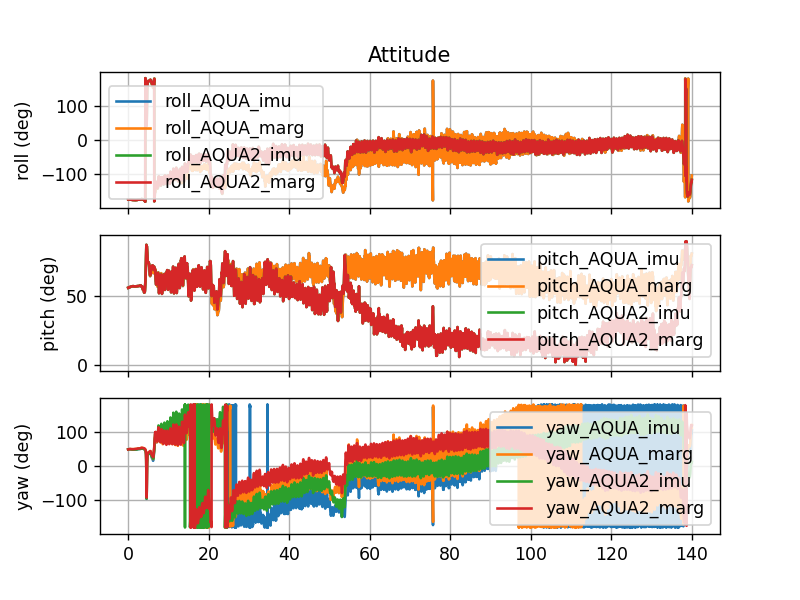

<IPython.core.display.Javascript object>


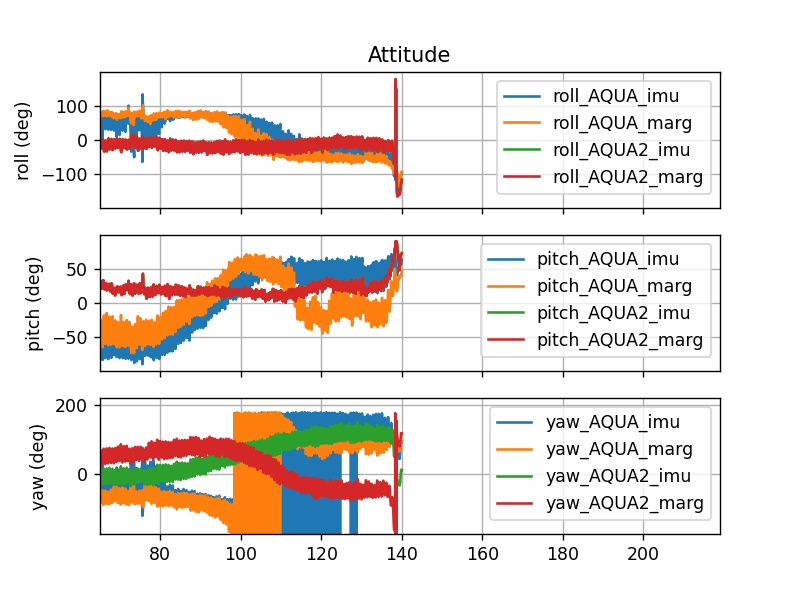

In [26]:
draw_attitude(orientations,label_text = ['AQUA_imu','AQUA_marg','AQUA2_imu','AQUA2_marg'])
draw_attitude(orientations2,label_text = ['AQUA_imu','AQUA_marg','AQUA2_imu','AQUA2_marg'])

In [27]:
g = 9.81
all_em = abs(np.linalg.norm(imu2[:,2:5],axis = 1)-g)/g

<IPython.core.display.Javascript object>


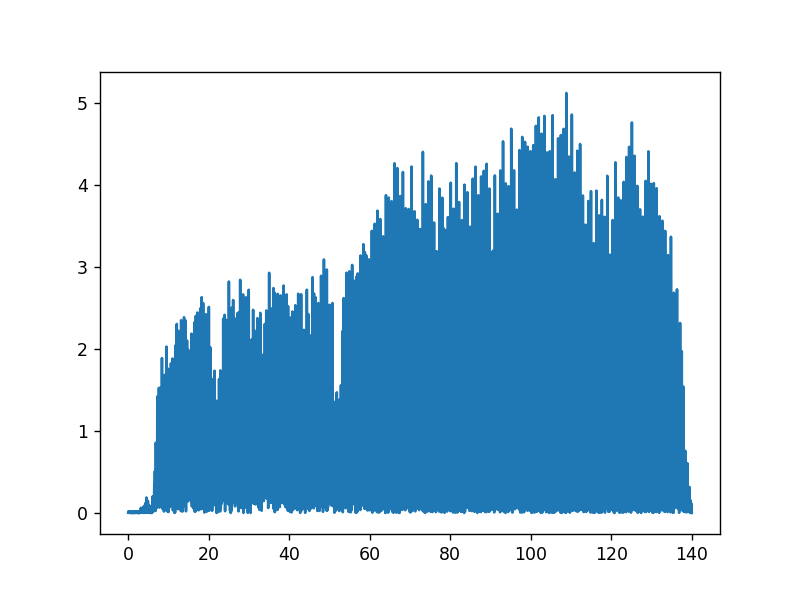

In [28]:
plt.figure()
plt.plot(imu2[:,1],all_em)
plt.show()

# EKF
The EKF provided in this source code only has state $x=\matrix[q_{w},q_{x},q_{y},q_{z}]$. It predicts the next state by using gyroscope reading. And the acceleration reading and magnetic field reading are used as update.

In [29]:
# Estimate the variance of MARG during static time
static_imu = imu[(imu[:,1]>0) & (imu[:,1]<4),:]
print('Average std of acceleration:',np.mean(np.std(static_imu[:,2:5], axis=0)))
print('Average std of gyro:',np.mean(np.std(static_imu[:,5:8], axis=0)))
print('Average std of mag:',np.mean(np.std(static_imu[:,8:11], axis=0)))


Average std of acceleration: 0.17908562816482373
Average std of gyro: 0.04661513939867234
Average std of mag: 2.075085187128845


In [30]:
# to get intial q_0, run Madwick with mag first to in order to find yaw_0
from ahrs.filters import EKF

attitude_ekf = EKF(acc=imu2[:,2:5], gyr=imu2[:,5:8], mag=imu2[:,8:11],frequency=62, noise = [0.18**2,0.05**2,2.1**2])


In [ ]:
euler_angles_ekf = np.asarray([ahrs.common.orientation.q2euler(s) for s in attitude_ekf.Q])
rpy_angles_ekf = np.asarray([ahrs.common.orientation.q2rpy(s) for s in attitude_ekf.Q])

orientations= np.hstack((imu2[:,1].reshape(-1,1),euler_angles_aqua2,euler_angles_marg_aqua2,
                         euler_angles_ekf))

Initial yaw is:59.10812920104615


<IPython.core.display.Javascript object>


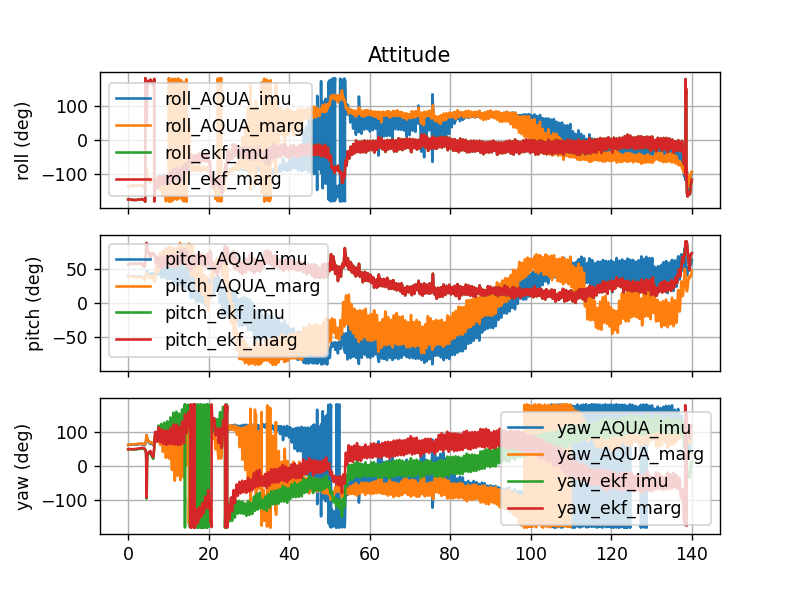

In [31]:
print(f'Initial yaw is:{q2rpy(attitude_ekf.Q[0])[2]*180/np.pi}')
draw_attitude(orientations2,label_text = ['AQUA_imu','AQUA_marg','ekf_imu','ekf_marg'])

In [32]:
# Evaluation of levlled acceleration
from ahrs.common.orientation import q_prod, q_conj

level_acc = np.asarray([q_prod(s, q_prod([0, *a], q_conj(s))) for a,s in zip(imu2[:,2:5],attitude_ekf.Q)])
level_gyro = np.asarray([q_prod(s, q_prod([0, *w], q_conj(s))) for w,s in zip(imu2[:,5:8],attitude_ekf.Q)])
level_mag = np.asarray([q_prod(s,q_prod([0,*m],q_conj(s))) for m,s in zip(imu2[:,8:11],attitude_ekf.Q)])

<IPython.core.display.Javascript object>


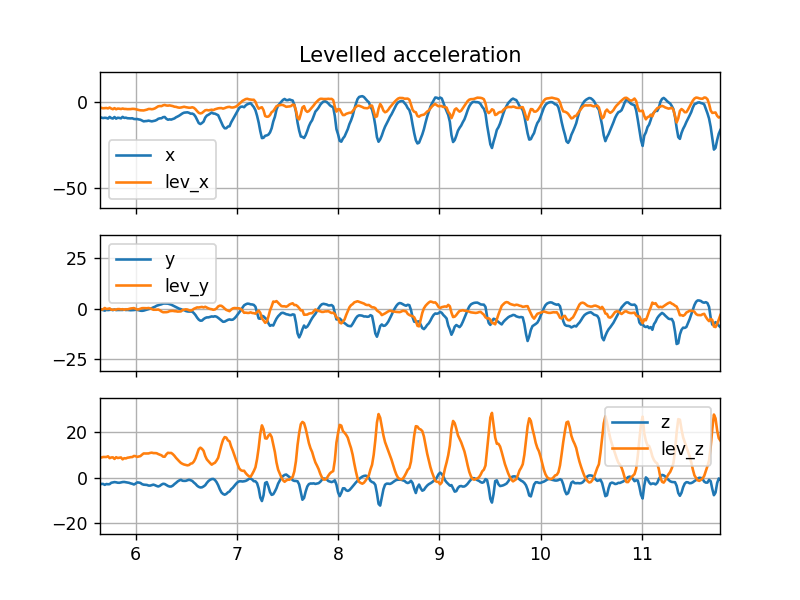

In [33]:
fig, axes = plt.subplots(3,1,sharex=True)
axes[0].set(title='Levelled acceleration')
axes[0].plot(imu2[:,1],np.hstack((imu2[:,2:3], level_acc[:,1:2])))
axes[1].plot(imu2[:,1],np.hstack((imu2[:,3:4], level_acc[:,2:3])))
axes[2].plot(imu2[:,1],np.hstack((imu2[:,4:5], level_acc[:,3:4])))
axes[0].legend(['x','lev_x'])
axes[0].grid()
axes[1].legend(['y','lev_y'])
axes[1].grid()
axes[2].legend(['z','lev_z'])
axes[2].grid()
plt.show()

<IPython.core.display.Javascript object>


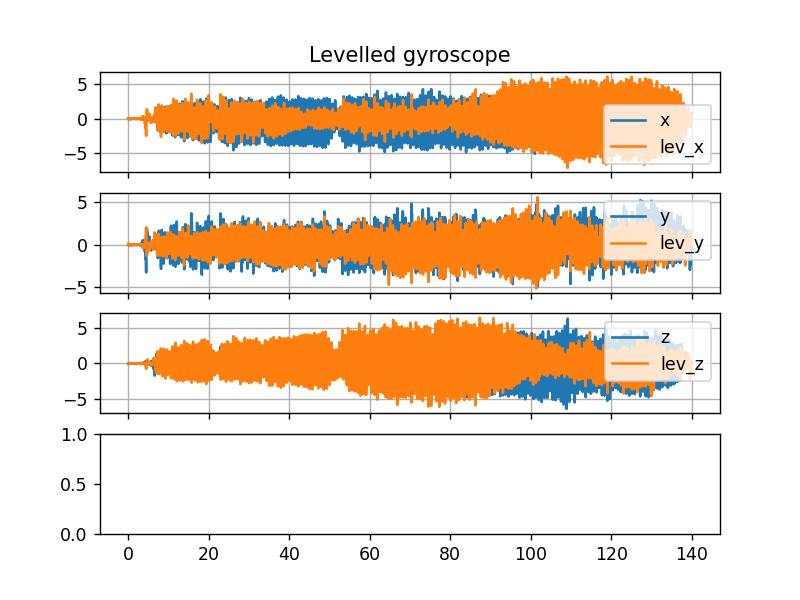

In [35]:
fig, axes = plt.subplots(4,1,sharex=True)

axes[0].set(title='Levelled gyroscope')
axes[0].plot(imu2[:,1],np.hstack((imu2[:,5:6], level_gyro[:,1:2])))
axes[1].plot(imu2[:,1],np.hstack((imu2[:,6:7], level_gyro[:,2:3])))
axes[2].plot(imu2[:,1],np.hstack((imu2[:,7:8], level_gyro[:,3:4])))
axes[0].legend(['x','lev_x'])
axes[0].grid()
axes[1].legend(['y','lev_y'])
axes[1].grid()
axes[2].legend(['z','lev_z'])
axes[2].grid()
plt.show()

<IPython.core.display.Javascript object>


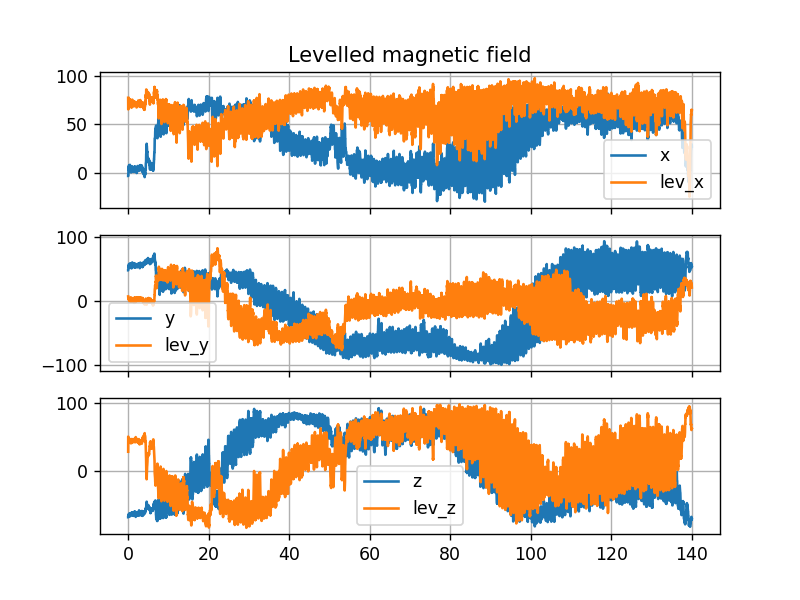

In [36]:
fig, axes = plt.subplots(3,1,sharex=True)
axes[0].set(title='Levelled magnetic field')
axes[0].plot(imu2[:,1],np.hstack((imu2[:,8:9], level_mag[:,1:2])))
axes[1].plot(imu2[:,1],np.hstack((imu2[:,9:10], level_mag[:,2:3])))
axes[2].plot(imu2[:,1],np.hstack((imu2[:,10:11], level_mag[:,3:4])))
axes[0].legend(['x','lev_x'])
axes[0].grid()
axes[1].legend(['y','lev_y'])
axes[1].grid()
axes[2].legend(['z','lev_z'])
axes[2].grid()
plt.show()

In [ ]:
yaw_0 = 70/180*np.pi
dt = 1/62
int_gyr_yaw = np.zeros(level_gyro.shape[0]+1)
int_gyr_yaw[0] = yaw_0
for i,gz in enumerate(level_gyro[:,3]):    
    int_gyr_yaw[i+1] = int_gyr_yaw[i]+gz*dt
    #print(f'{i} epoch: w+delta w = {int_gyr_yaw[i]*180/np.pi}+{gz*dt*180/np.pi}= {int_gyr_yaw[i+1]*180/np.pi} degree' )
    if int_gyr_yaw[i+1] > np.pi:
        int_gyr_yaw[i+1] -= 2*np.pi 
    if int_gyr_yaw[i+1] < -np.pi:
        int_gyr_yaw[i+1] += 2*np.pi 
    
plt.figure()
plt.plot(int_gyr_yaw*180/np.pi)
plt.show()


In [ ]:
# Easy PDR algorithm
b_0 = np.mean(imu2[imu2[:,1]<2,2:],axis=0)
acc_norm_bias = np.linalg.norm(b_0[:3])
print(f'acceleration turn on bias:{acc_norm_bias}')
print(f'gyroscope turn on bias:{b_0[3:6]}')
plt.figure()
plt.plot(imu2[:,1],level_acc[:,3]-acc_norm_bias)
plt.grid()
for epoch, imu in enumerate(imu2):
    # stride detection
    while epoch > 2*data_rate:
        [h_peaks, l_peaks] = peaks_detection(level_acc[epoch-2*data_rate:epoch,3], -2): #temporary treshold
        if h_peaks.shape[0]+l_peaks.shape[0] > 2: # effective cycle
            steps_detected[count] = min()
        

In [ ]:
def peaks_detection(signal, threshold):
    #seek_h = True if signal[1] > signal[0] else False
    #seek_h=False
    h_peaks = []
    l_peaks = []
    slops_pod = [0]
    range_s = np.max(signal)-np.min(signal)
    for i in range(signal.shape[0]):
        if i > 1:
            slops_pod.append((signal[i]- signal[i-1])*(signal[i-1]-signal[i-2]))
            if (signal[i]*signal[i-1]) < 0:
                if (signal[i]-signal[i-1]) > range_s*0.05: # zero crossing with significant change
                    h_peaks.append([i-1, signal[i-1]])
                if (signal[i-1]-signal[i]) > range_s*0.05:
                    l_peaks.append([i-1, signal[i-1]])
                    
    #return h_peaks, l_peaks
    return np.asarray(h_peaks), np.asarray(l_peaks)

In [ ]:
h_peaks, l_peaks = peaks_detection(level_acc[imu2[:,1] < 8, 3]-acc_norm_bias,2.5)
#l_peaks = peaks_detection(level_acc[imu2[:,1] < 8, 3]-acc_norm_bias,2.5)

In [ ]:
print(f'high peaks: {h_peaks}')
print(f'lw peaks: {l_peaks}')

In [ ]:
plt.figure()
plt.plot(level_acc[imu2[:,1] < 8, 3])
plt.plot(l_peaks[:,0], l_peaks[:,1]+acc_norm_bias,"r*")
plt.plot(h_peaks[:,0], h_peaks[:,1]+acc_norm_bias,"g*")
plt.grid()